In [ ]:
from platform import python_version
print(python_version())

A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [11]:
import tensorflow

In [12]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('../data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
#{k:all_image_paths[k] for k in all_image_paths.keys()[:5]}
list(all_image_paths.items())[:4]
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}



[('00018942_001.png', '../data/images_009/images/00018942_001.png'),
 ('00020323_001.png', '../data/images_009/images/00020323_001.png'),
 ('00018730_001.png', '../data/images_009/images/00018730_001.png'),
 ('00019551_000.png', '../data/images_009/images/00019551_000.png')]

In [13]:
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
print(list(tmp.items())[:4])
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120
[('00002587_005.png', '../data/images_002/images/00002587_005.png'), ('00002588_000.png', '../data/images_002/images/00002588_000.png'), ('00002589_000.png', '../data/images_002/images/00002589_000.png'), ('00002589_001.png', '../data/images_002/images/00002589_001.png')]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
91714,00022870_018.png,Atelectasis,18,22870,62,M,AP,3056,2544,0.139,0.139,NaN,../data/images_010/images/00022870_018.png
58956,00014594_000.png,No Finding,0,14594,25,M,PA,2992,2991,0.143,0.143,NaN,../data/images_007/images/00014594_000.png
35036,00009237_025.png,Nodule,25,9237,52,F,PA,2662,2511,0.143,0.143,NaN,../data/images_005/images/00009237_025.png


In [14]:
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                                         54652
Infiltration                                                                        8734
Atelectasis                                                                         3848
Effusion                                                                            3659
Nodule                                                                              2495
Mass                                                                                2015
Pneumothorax                                                                        1972
Effusion|Infiltration                                                               1511
Atelectasis|Infiltration                                                            1237
Consolidation                                                                       1199
Atelectasis|Effusion                                                                1091
Pleural_Thickening   

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

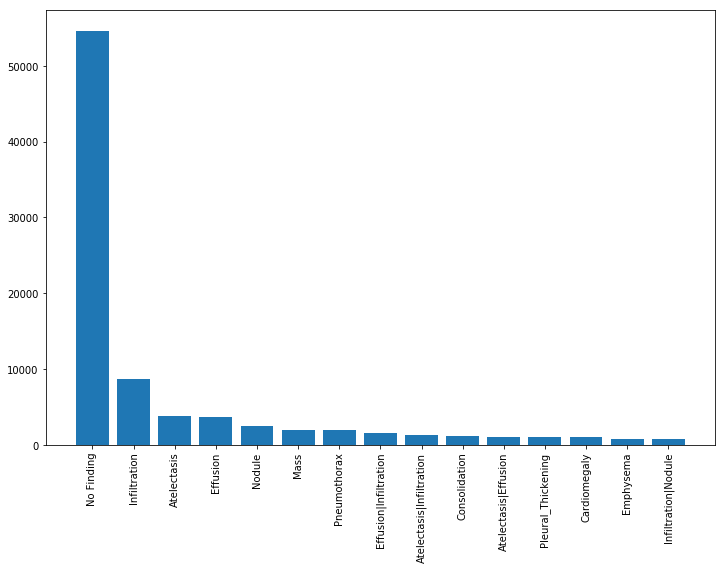

In [15]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [16]:
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
75203,00018451_002.png,Infiltration,2,18451,52,F,PA,2774,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11971,00003122_018.png,No Finding,18,3122,58,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38430,00010049_000.png,No Finding,0,10049,31,M,PA,2346,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [18]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('No Finding', 54652), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


In [19]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
86005,00021203_000.png,No Finding,0,21203,42,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
43161,00011140_010.png,No Finding,10,11140,40,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54781,00013698_000.png,No Finding,0,13698,62,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
for c_label, s_count in zip(all_labels, np.mean(all_xray_df[all_labels].values,0)):
    print('%s: %f' % (c_label, s_count))
arrivals=np.array(np.mean(all_xray_df[all_labels].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
print(arrivals)

Atelectasis: 0.104485
Cardiomegaly: 0.024246
Consolidation: 0.041823
Edema: 0.021054
Effusion: 0.121524
Emphysema: 0.022474
Fibrosis: 0.013778
Infiltration: 0.179113
Mass: 0.053408
No Finding: 0.535174
Nodule: 0.057648
Pleural_Thickening: 0.029965
Pneumonia: 0.012691
Pneumothorax: 0.047611
[0.08259729 0.01916691 0.03306214 0.01664331 0.09606676 0.01776577
 0.01089169 0.14159203 0.04221983 0.42306531 0.04557172 0.02368769
 0.01003244 0.03763711]


In [21]:
print(all_xray_df[all_labels].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64


# Label the type of each image and create a training data-set that is balanced across all image types


In [22]:
def image_type(X):
    if any(item =='Pneumothorax' for item in X):
        return 1
    elif any(item =='Emphysema' for item in X):
        return 2
    elif any(item =='Pneumonia' for item in X):
        return 3
    elif any(item =='Edema' for item in X):
        return 4
    elif any(item =='Consolidation' for item in X):
        return 5
    elif any(item =='Effusion' for item in X):
        return 6
    elif any(item =='Infiltration' for item in X):
        return 7
    elif any(item =='Atelectasis' for item in X):
        return 8
    elif any(item =='Cardiomegaly' for item in X):
        return 9
    elif any(item =='Pleural_Thickening' for item in X):
        return 10
    elif any(item =='Fibrosis' for item in X):
        return 11
    elif any(item =='Mass' for item in X):
        return 12
    elif any(item =='Nodule' for item in X):
        return 13
    else:
        return 14
def rank_disease(item):
    if item =='Pneumothorax':
        return 1
    elif item =='Emphysema':
        return 2
    elif item =='Pneumonia':
        return 3
    elif item =='Edema':
        return 4
    elif item =='Consolidation':
        return 5
    elif item =='Effusion':
        return 6
    elif item =='Infiltration':
        return 7
    elif item =='Atelectasis':
        return 8
    elif item =='Cardiomegaly':
        return 9
    elif item =='Pleural_Thickening':
        return 10
    elif item =='Fibrosis':
        return 11
    elif item =='Mass':
        return 12
    elif item =='Nodule':
        return 13
    else:
        return 14

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [23]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
from itertools import chain
all_xray_df['Type']=all_xray_df['Finding Labels'].map(lambda x: image_type(x.split('|')))

In [24]:
print(all_xray_df[['Type','Finding Labels']].sample(10))


       Type              Finding Labels
98757     5   Atelectasis|Consolidation
14134    14                  No Finding
23763     5  Consolidation|Infiltration
55656     6       Effusion|Infiltration
70753     2                   Emphysema
37859     6        Atelectasis|Effusion
51209     6                    Effusion
49205    14                  No Finding
57220    14                  No Finding
57100    14                  No Finding


In [25]:
print(all_xray_df['Type'].value_counts())

14    54740
7     12078
6      9474
1      4862
8      4577
5      3758
13     2501
12     2410
4      1793
2      1602
10     1360
3      1243
9      1043
11      679
Name: Type, dtype: int64


In [26]:
print(all_xray_df[all_labels].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64


In [27]:
from sklearn.model_selection import train_test_split
train_df, valid_test_df = train_test_split(all_xray_df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Type'])

In [28]:
valid_df, test_df = train_test_split(valid_test_df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = valid_test_df['Type'])

In [29]:
print('train', train_df.shape, 'validation', valid_df.shape,'test', test_df.shape)

train (51060, 30) validation (25530, 30) test (25530, 30)


In [30]:
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabelT'] = train_df['Type']
print(train_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
80526  00019772_001.png     No Finding            1       19772           73   
84145  00020679_000.png     No Finding            0       20679           69   
44082  00011364_000.png     No Finding            0       11364           53   

      Patient Gender View Position  OriginalImage[Width  Height]  \
80526              M            AP                 2500     2048   
84145              M            PA                 2992     2991   
44082              F            PA                 2614     2873   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
80526                        0.168  ...   0.0         1.0    0.0   
84145                        0.143  ...   0.0         1.0    0.0   
44082                        0.143  ...   0.0         1.0    0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
80526                 0.0        0.0           0.0   
84145                 0.0

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabelT'] = valid_df['Type']
print(valid_df.sample(3))

            Image Index     Finding Labels  Follow-up #  Patient ID  \
70000  00017236_082.png       Infiltration           82       17236   
79501  00019528_013.png         No Finding           13       19528   
24318  00006391_001.png  Atelectasis|Edema            1        6391   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
70000           46              M            AP                 2500     2048   
79501           54              M            PA                 2992     2991   
24318            9              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
70000                        0.168  ...   0.0         0.0    0.0   
79501                        0.143  ...   0.0         1.0    0.0   
24318                        0.171  ...   0.0         0.0    0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
70000                 0.0        0.0           0.0   
79501    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabelT'] = test_df['Type']
print(test_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
72735  00017927_000.png   Infiltration            0       17927           26   
43721  00011259_000.png     No Finding            0       11259           30   
83901  00020624_012.png     No Finding           12       20624           70   

      Patient Gender View Position  OriginalImage[Width  Height]  \
72735              M            AP                 2500     2048   
43721              M            PA                 2926     2829   
83901              M            PA                 3056     2516   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
72735                        0.168  ...   0.0         0.0    0.0   
43721                        0.143  ...   0.0         1.0    0.0   
83901                        0.139  ...   0.0         1.0    0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
72735                 0.0        0.0           0.0   
43721                 0.0

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AxesSubplot(0.125,0.125;0.775x0.755)


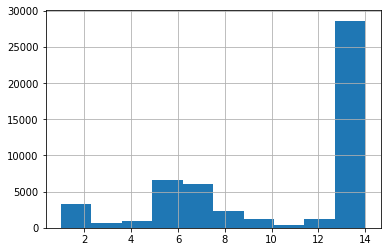

In [33]:
print(train_df['Type'].hist())

In [34]:
#from imblearn.over_sampling import SMOTE

In [35]:
#pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

In [36]:
from sklearn.preprocessing import LabelEncoder
y=train_df['Type']

In [37]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(train_df, y)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


In [38]:
X_res.shape

(383180, 32)

In [39]:
train_df.shape

(51060, 32)

AxesSubplot(0.125,0.125;0.775x0.755)


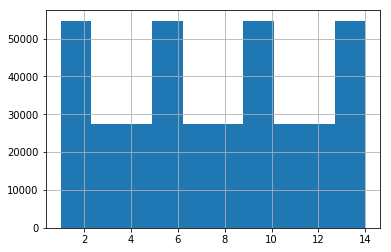

In [40]:
train_df=X_res
print(train_df['Type'].hist())

# Training the Model

In [41]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

In [42]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model
def MakeModel2(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels),activation = 'sigmoid'))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model

In [43]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [44]:
n_priorities=4

In [45]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
batch = int(256 / batchSize)
STEPS_PER_EPOCH = 1000
EPOCHS = 100
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.sequential.january_2022.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]


train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize) # we can use much larger batches for evaluation


opt = tensorflow.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


Found 383139 validated image filenames belonging to 14 classes.
Found 25510 validated image filenames belonging to 14 classes.


In [ ]:
import gc
gc.collect()
multi_disease_model = MakeModel1(imageSize, batchSize, channels)
multi_disease_model.load_weights("xray_class_weights.best.sequential.june9.hdf5")

In [ ]:
multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
       metrics = ['binary_accuracy', 'mae'])

history = multi_disease_model.fit_generator(train_gen,                           
              validation_data = valid_gen, 
              steps_per_epoch=1000,                              
              epochs = 20, 
              callbacks = callbacks_list)

In [ ]:
import gc
gc.collect()

In [68]:
import tensorflow as tf

In [69]:
tf.keras.backend.clear_session()

In [144]:
multi_disease_model = MakeModel1(imageSize, batchSize, channels)
multi_disease_model.load_weights("xray_class_weights.best.sequential.january_2022.hdf5")

In [142]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = imageSize,
                             color_mode = colorMode,
                            batch_size = 2000))

Found 25510 validated image filenames belonging to 14 classes.


In [145]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 1, verbose = True)

2000/2000 [==============================] - 27s 13ms/step


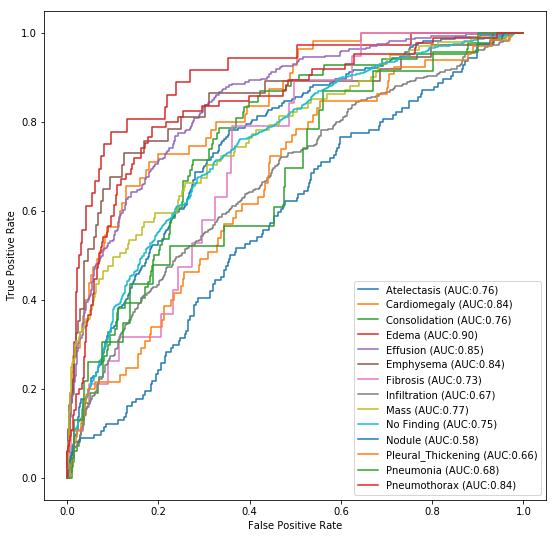

In [146]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net_january_2022.pdf')

In [82]:
test_df.shape

(25530, 32)

In [84]:
test_df.to_csv('test_df_january_22.csv', index=False)

In [147]:
del multi_disease_model

# Computing the Youden Index Thresholds and the Type-Classification Matrix Q

In [148]:
disease_thresholds={}

In [149]:
disease_thresholds

{}

In [150]:
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    #disease_thresholds.loc[len(disease_thresholds.index)] = [c_label,2]
    disease_thresholds[c_label]=optimal_threshold


In [151]:
disease_thresholds

{'Atelectasis': 0.10676851,
 'Cardiomegaly': 0.043366976,
 'Consolidation': 0.06581639,
 'Edema': 0.14420465,
 'Effusion': 0.045613006,
 'Emphysema': 0.100178234,
 'Fibrosis': 0.06619118,
 'Infiltration': 0.20058593,
 'Mass': 0.17318188,
 'No Finding': 0.1090359,
 'Nodule': 0.16145295,
 'Pleural_Thickening': 0.04642132,
 'Pneumonia': 0.04213357,
 'Pneumothorax': 0.05543855}

In [152]:
disease_thresholds['Consolidation']

0.06581639

In [153]:
import pickle

In [154]:
a_file = open("data_disease_thresholds.pkl", "wb")

In [155]:
pickle.dump(disease_thresholds, a_file)

In [156]:
a_file.close()

In [96]:
np.array(disease_thresholds.values())

array(dict_values([0.1033651, 0.02430491, 0.0909833, 0.063854836, 0.05434157, 0.12722923, 0.12196326, 0.20064068, 0.23371999, 0.110839285, 0.17452836, 0.069686554, 0.049683064, 0.049669754]),
      dtype=object)

In [97]:
set=disease_thresholds.values()
set

dict_values([0.1033651, 0.02430491, 0.0909833, 0.063854836, 0.05434157, 0.12722923, 0.12196326, 0.20064068, 0.23371999, 0.110839285, 0.17452836, 0.069686554, 0.049683064, 0.049669754])

In [98]:
set=np.array(list(set))
set

array([0.1033651 , 0.02430491, 0.0909833 , 0.06385484, 0.05434157,
       0.12722923, 0.12196326, 0.20064068, 0.23371999, 0.11083928,
       0.17452836, 0.06968655, 0.04968306, 0.04966975], dtype=float32)

In [99]:
set=pd.DataFrame(set)

In [100]:
set=pd.DataFrame(set.T)

In [101]:
set=pd.concat([set]*test_Y.shape[0])

In [102]:
def image_type_vector(X):
    set=X
    pet=set[set==1].index.tolist()
    return(image_type([all_labels[i] for i in pet]))

In [103]:
data1=pd.DataFrame(test_Y).apply(lambda row : image_type_vector(row), axis = 1)
data2=(1+np.sign(pred_Y-set))/2

In [104]:
data2=pd.DataFrame(data2).apply(lambda row : image_type_vector(row), axis = 1)

In [105]:
data2.index=range(test_Y.shape[0])

In [106]:
from sklearn.metrics import confusion_matrix

In [107]:
mat1=confusion_matrix(data1,data2,labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [108]:
pd.DataFrame(mat1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,79,0,13,0,0,0,0,1,2,5,1,0,2,0
1,17,1,4,0,0,0,0,2,2,0,0,1,2,0
2,6,0,11,0,0,0,0,0,2,0,0,1,0,0
3,13,1,19,0,0,0,0,0,0,0,0,0,0,0
4,20,1,29,0,0,1,0,1,2,1,2,1,0,0
5,88,5,61,0,2,4,0,4,11,5,1,0,0,0
6,44,2,91,1,1,1,0,7,19,17,10,4,22,1
7,19,1,30,1,1,1,0,6,4,9,1,2,1,0
8,2,0,5,0,0,0,0,1,13,0,0,0,0,0
9,12,0,3,0,0,0,0,0,2,8,0,1,0,0


In [109]:
mat1.sum(axis=1).shape

(14,)

In [112]:
Q_Youden=pd.DataFrame(mat1/mat1.sum(axis=1).reshape(-1,1))
b_file = open("Q_Youden.pkl", "wb")
pickle.dump(Q_Youden, b_file)
b_file.close()

In [113]:
len(all_labels)

14

In [114]:
[0.5]*len(all_labels)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [115]:
set=[0.5]*len(all_labels)
set=pd.DataFrame(set)
set=pd.DataFrame(set.T)
set=pd.concat([set]*test_Y.shape[0])
def image_type_vector(X):
    set=X
    pet=set[set==1].index.tolist()
    return(image_type([all_labels[i] for i in pet]))
data1=pd.DataFrame(test_Y).apply(lambda row : image_type_vector(row), axis = 1)
data2=(1+np.sign(pred_Y-set))/2
data2=pd.DataFrame(data2).apply(lambda row : image_type_vector(row), axis = 1)
data2.index=range(test_Y.shape[0])
mat1=confusion_matrix(data1,data2,labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
pd.DataFrame(mat1)
pd.DataFrame(mat1/mat1.sum(axis=1).reshape(-1,1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.097087,0.0,0.000000,0.0,0.019417,0.000000,0.029126,0.000000,0.0,0.000000,0.009709,0.0,0.844660
1,0.034483,0.206897,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.034483,0.0,0.000000,0.000000,0.0,0.724138
2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.100000,0.000000,0.0,0.000000,0.050000,0.0,0.850000
3,0.000000,0.000000,0.0,0.030303,0.0,0.030303,0.060606,0.000000,0.060606,0.0,0.000000,0.030303,0.0,0.787879
4,0.000000,0.000000,0.0,0.000000,0.0,0.051724,0.000000,0.017241,0.000000,0.0,0.017241,0.068966,0.0,0.844828
5,0.000000,0.011050,0.0,0.000000,0.0,0.127072,0.005525,0.022099,0.022099,0.0,0.011050,0.016575,0.0,0.784530
6,0.000000,0.018182,0.0,0.009091,0.0,0.004545,0.004545,0.004545,0.009091,0.0,0.013636,0.022727,0.0,0.913636
7,0.000000,0.000000,0.0,0.000000,0.0,0.039474,0.000000,0.065789,0.000000,0.0,0.000000,0.026316,0.0,0.868421
8,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.380952,0.0,0.000000,0.000000,0.0,0.619048
9,0.000000,0.076923,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.038462,0.076923,0.0,0.807692


In [117]:
Q_point_five=pd.DataFrame(mat1/mat1.sum(axis=1).reshape(-1,1))
c_file = open("Q_point_five.pkl", "wb")
pickle.dump(Q_point_five, c_file)
c_file.close()

# Write a function that gives the best partitioning given a type classification matrix Q and number of queues N. 

In [118]:
def queue_wait_cost(pmat,costs,arrivals,service):
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)

In [119]:
def partition(collection):
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[:1]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [first + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ first ] + smaller

In [120]:
something = list(range(1,15))

z=enumerate(partition(something), 1)

In [122]:
len(list_partitions)

10391745

In [123]:
del list_partitions

In [124]:
Q_Youden

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.766990,0.000000,0.126214,0.000000,0.000000,0.000000,0.0,0.009709,0.019417,0.048544,0.009709,0.000000,0.019417,0.000000
1,0.586207,0.034483,0.137931,0.000000,0.000000,0.000000,0.0,0.068966,0.068966,0.000000,0.000000,0.034483,0.068966,0.000000
2,0.300000,0.000000,0.550000,0.000000,0.000000,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.050000,0.000000,0.000000
3,0.393939,0.030303,0.575758,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.344828,0.017241,0.500000,0.000000,0.000000,0.017241,0.0,0.017241,0.034483,0.017241,0.034483,0.017241,0.000000,0.000000
5,0.486188,0.027624,0.337017,0.000000,0.011050,0.022099,0.0,0.022099,0.060773,0.027624,0.005525,0.000000,0.000000,0.000000
6,0.200000,0.009091,0.413636,0.004545,0.004545,0.004545,0.0,0.031818,0.086364,0.077273,0.045455,0.018182,0.100000,0.004545
7,0.250000,0.013158,0.394737,0.013158,0.013158,0.013158,0.0,0.078947,0.052632,0.118421,0.013158,0.026316,0.013158,0.000000
8,0.095238,0.000000,0.238095,0.000000,0.000000,0.000000,0.0,0.047619,0.619048,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.461538,0.000000,0.115385,0.000000,0.000000,0.000000,0.0,0.000000,0.076923,0.307692,0.000000,0.038462,0.000000,0.000000


In [125]:
Q_point_five

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.097087,0.0,0.000000,0.0,0.019417,0.000000,0.029126,0.000000,0.0,0.000000,0.009709,0.0,0.844660
1,0.034483,0.206897,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.034483,0.0,0.000000,0.000000,0.0,0.724138
2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.100000,0.000000,0.0,0.000000,0.050000,0.0,0.850000
3,0.000000,0.000000,0.0,0.030303,0.0,0.030303,0.060606,0.000000,0.060606,0.0,0.000000,0.030303,0.0,0.787879
4,0.000000,0.000000,0.0,0.000000,0.0,0.051724,0.000000,0.017241,0.000000,0.0,0.017241,0.068966,0.0,0.844828
5,0.000000,0.011050,0.0,0.000000,0.0,0.127072,0.005525,0.022099,0.022099,0.0,0.011050,0.016575,0.0,0.784530
6,0.000000,0.018182,0.0,0.009091,0.0,0.004545,0.004545,0.004545,0.009091,0.0,0.013636,0.022727,0.0,0.913636
7,0.000000,0.000000,0.0,0.000000,0.0,0.039474,0.000000,0.065789,0.000000,0.0,0.000000,0.026316,0.0,0.868421
8,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.380952,0.0,0.000000,0.000000,0.0,0.619048
9,0.000000,0.076923,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.038462,0.076923,0.0,0.807692


In [126]:
from itertools import combinations
types=14
queues=4

In [127]:
combination_lists=list(combinations(range(types-1),queues-1))

In [128]:
combination_lists

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 1, 10),
 (0, 1, 11),
 (0, 1, 12),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 2, 10),
 (0, 2, 11),
 (0, 2, 12),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 3, 9),
 (0, 3, 10),
 (0, 3, 11),
 (0, 3, 12),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 4, 9),
 (0, 4, 10),
 (0, 4, 11),
 (0, 4, 12),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 5, 9),
 (0, 5, 10),
 (0, 5, 11),
 (0, 5, 12),
 (0, 6, 7),
 (0, 6, 8),
 (0, 6, 9),
 (0, 6, 10),
 (0, 6, 11),
 (0, 6, 12),
 (0, 7, 8),
 (0, 7, 9),
 (0, 7, 10),
 (0, 7, 11),
 (0, 7, 12),
 (0, 8, 9),
 (0, 8, 10),
 (0, 8, 11),
 (0, 8, 12),
 (0, 9, 10),
 (0, 9, 11),
 (0, 9, 12),
 (0, 10, 11),
 (0, 10, 12),
 (0, 11, 12),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 2, 7),
 (1, 2, 8),
 (1, 2, 9),
 (1, 2, 10),
 (1, 2, 11),
 (1, 2, 12),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 3, 7),
 (1,

In [129]:
mat=np. zeros((types,queues))
mat[0,1]

0.0

In [130]:
def partition_matrix(partition):
    mat=np.zeros((types,queues))
    for i in range(1,queues-1):
        for j in range((partition[i-1]+1),partition[i]+1):
                mat[j,i]=1
    for j in range(partition[0]+1):
        mat[j,0]=1
    for j in range(partition[queues-2]+1,types):
        mat[j,(queues-1)]=1
    return mat   

In [131]:
partition_matrix((0,1,12))

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [132]:
Q_Youden.shape

(14, 14)

In [133]:
partition_matrix((0,1,12)).shape

(14, 4)

In [134]:
np.dot(Q_Youden,partition_matrix((0,1,12)))

array([[0.76699029, 0.        , 0.23300971, 0.        ],
       [0.5862069 , 0.03448276, 0.37931034, 0.        ],
       [0.3       , 0.        , 0.7       , 0.        ],
       [0.39393939, 0.03030303, 0.57575758, 0.        ],
       [0.34482759, 0.01724138, 0.63793103, 0.        ],
       [0.48618785, 0.02762431, 0.48618785, 0.        ],
       [0.2       , 0.00909091, 0.78636364, 0.00454545],
       [0.25      , 0.01315789, 0.73684211, 0.        ],
       [0.0952381 , 0.        , 0.9047619 , 0.        ],
       [0.46153846, 0.        , 0.53846154, 0.        ],
       [0.35714286, 0.        , 0.64285714, 0.        ],
       [0.26415094, 0.03773585, 0.69811321, 0.        ],
       [0.26785714, 0.        , 0.71428571, 0.01785714],
       [0.15675676, 0.01081081, 0.83063063, 0.0018018 ]])

In [135]:
np.dot(Q_point_five,partition_matrix((0,1,12)))

array([[0.00000000e+00, 9.70873786e-02, 5.82524272e-02, 8.44660194e-01],
       [3.44827586e-02, 2.06896552e-01, 3.44827586e-02, 7.24137931e-01],
       [0.00000000e+00, 0.00000000e+00, 1.50000000e-01, 8.50000000e-01],
       [0.00000000e+00, 0.00000000e+00, 2.12121212e-01, 7.87878788e-01],
       [0.00000000e+00, 0.00000000e+00, 1.55172414e-01, 8.44827586e-01],
       [0.00000000e+00, 1.10497238e-02, 2.04419890e-01, 7.84530387e-01],
       [0.00000000e+00, 1.81818182e-02, 6.81818182e-02, 9.13636364e-01],
       [0.00000000e+00, 0.00000000e+00, 1.31578947e-01, 8.68421053e-01],
       [0.00000000e+00, 0.00000000e+00, 3.80952381e-01, 6.19047619e-01],
       [0.00000000e+00, 7.69230769e-02, 1.15384615e-01, 8.07692308e-01],
       [0.00000000e+00, 0.00000000e+00, 7.14285714e-02, 9.28571429e-01],
       [0.00000000e+00, 1.88679245e-02, 3.39622642e-01, 6.41509434e-01],
       [0.00000000e+00, 0.00000000e+00, 1.07142857e-01, 8.92857143e-01],
       [9.00900901e-04, 8.10810811e-03, 6.84684685e

In [136]:
list_partition_matrices = list(map(partition_matrix, combination_lists))

In [137]:
list_partition_matrices[1]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [138]:
def get_pmat_q_youden(partition_matrix):
    return np.dot(Q_Youden,partition_matrix)
def get_pmat_q_point_five(partition_matrix):
    return np.dot(Q_point_five,partition_matrix)
def get_pmat_q_identity(partition_matrix):
    return np.dot(np.identity(types),partition_matrix)

In [139]:
get_pmat_q_youden(list_partition_matrices[1])

array([[0.76699029, 0.        , 0.12621359, 0.10679612],
       [0.5862069 , 0.03448276, 0.13793103, 0.24137931],
       [0.3       , 0.        , 0.55      , 0.15      ],
       [0.39393939, 0.03030303, 0.57575758, 0.        ],
       [0.34482759, 0.01724138, 0.5       , 0.13793103],
       [0.48618785, 0.02762431, 0.33701657, 0.14917127],
       [0.2       , 0.00909091, 0.41818182, 0.37272727],
       [0.25      , 0.01315789, 0.40789474, 0.32894737],
       [0.0952381 , 0.        , 0.23809524, 0.66666667],
       [0.46153846, 0.        , 0.11538462, 0.42307692],
       [0.35714286, 0.        , 0.21428571, 0.42857143],
       [0.26415094, 0.03773585, 0.11320755, 0.58490566],
       [0.26785714, 0.        , 0.26785714, 0.46428571],
       [0.15675676, 0.01081081, 0.32072072, 0.51171171]])

In [140]:
get_pmat_q_point_five(list_partition_matrices[1])

array([[0.00000000e+00, 9.70873786e-02, 0.00000000e+00, 9.02912621e-01],
       [3.44827586e-02, 2.06896552e-01, 0.00000000e+00, 7.58620690e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.03030303e-02, 9.69696970e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.10497238e-02, 0.00000000e+00, 9.88950276e-01],
       [0.00000000e+00, 1.81818182e-02, 9.09090909e-03, 9.72727273e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 7.69230769e-02, 0.00000000e+00, 9.23076923e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.88679245e-02, 0.00000000e+00, 9.81132075e-01],
       [0.00000000e+00, 0.00000000e+00, 1.78571429e-02, 9.82142857e-01],
       [9.00900901e-04, 8.10810811e-03, 3.60360360e

In [141]:
get_pmat_q_identity(list_partition_matrices[1])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
arrivals=np.array(np.mean(train_df['Type'].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
print(arrivals)

In [ ]:
type(test_df['Type'].value_counts())

In [ ]:
types_test_data=pd.Series(test_df['Type'].value_counts().index)

In [ ]:
types_test_data

In [ ]:
counts_types_test_data=pd.Series(test_df['Type'].value_counts())

In [ ]:
arrivals_types_test_data=counts_types_test_data/counts_types_test_data.sum(axis=0)

In [ ]:
arrivals_types_test_data

In [ ]:
pd.DataFrame({'Type':types_test_data.values,'Arrival_Rates':arrivals_types_test_data.values}).sort_values('Type', ascending=True)

In [ ]:
def get_arrival_rates_types(data):
    types_test_data=pd.Series(data['Type'].value_counts().index)
    counts_types_test_data=pd.Series(data['Type'].value_counts())
    arrivals_types_test_data=counts_types_test_data/counts_types_test_data.sum(axis=0)
    return pd.DataFrame({'Type':types_test_data.values,'Arrival_Rates':arrivals_types_test_data.values}).sort_values('Type', ascending=True)['Arrival_Rates'].values   

In [ ]:
get_arrival_rates_types(test_df)

In [ ]:
def get_costs_types(r):
    return [r**(types-rank-1) for rank in range(types)]

In [ ]:
get_costs_types(2)

In [ ]:
def get_service_rates_types(rho):
    return [1/rho]*types

In [ ]:
get_service_rates_types(0.9)

In [ ]:
queue_wait_cost(get_pmat_q_youden(list_partition_matrices[200]),get_costs_types(2),get_arrival_rates_types(test_df),get_service_rates_types(0.9))

In [ ]:
[queue_wait_cost(get_pmat_q_youden(X),get_costs_types(2),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.6)) for X in list_partition_matrices]

In [ ]:
np.argmin([queue_wait_cost(get_pmat_q_youden(X),get_costs_types(2),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.6)) for X in list_partition_matrices])

In [ ]:
list_partition_matrices[33]

In [ ]:
np.argmin([queue_wait_cost(get_pmat_q_point_five(X),get_costs_types(2),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.6)) for X in list_partition_matrices])

In [ ]:
list_partition_matrices[14]

In [ ]:
np.argmin([queue_wait_cost(get_pmat_q_identity(X),get_costs_types(2),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.6)) for X in list_partition_matrices])

In [ ]:
list_partition_matrices[88]